This notebook illustrates training the yolo_captcha model

# Initialization

In [47]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
import matplotlib.pyplot as plt

from gen_anchors import run_kmeans
from create_model import build_yolo_model
from preprocessing_capcha import BatchGenerator
from generating_capcha import capcha_list ,capcha_gen_annotate
from utils import normalize,custom_loss,load_model_from_original_yolo_weights
from constants import *

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

%matplotlib inline

# Explore the dataset

In [40]:
im_dt=capcha_gen_annotate(seed=0)
all_imgs=capcha_list()

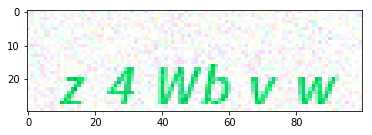

In [41]:
plt.imshow(all_imgs[0]['filename'])

## Get right anchors

In [42]:
grid_w = IMAGE_H/32
grid_h = IMAGE_W/32
annotation_dims = []
i=1000
for image in all_imgs:
    i=i+1
    cell_w = image['width']/grid_w
    cell_h = image['height']/grid_h
    for obj in image['object']:
        relative_w = (float(obj['xmax']) - float(obj['xmin']))/cell_w
        relatice_h = (float(obj["ymax"]) - float(obj['ymin']))/cell_h
        annotation_dims.append(tuple(map(float, (relative_w,relatice_h))))
    if i==1100:
        break
annotation_dims = np.array(annotation_dims)
centroids = run_kmeans(annotation_dims, BOX)
anchors = centroids.copy()

widths = anchors[:, 0]
sorted_indices = np.argsort(widths)

r = "anchors: ["
for i in sorted_indices[:-1]:
    r += '%0.2f,%0.2f, ' % (anchors[i,0], anchors[i,1])

#there should not be comma after last anchor, that's why
r += '%0.2f,%0.2f' % (anchors[sorted_indices[-1:],0], anchors[sorted_indices[-1:],1])
r += "]"

print(r)

iteration 1: dists = 927.2506002208064
iteration 2: dists = 536.7335500224042
iteration 3: dists = 31.942452009185466
iteration 4: dists = 18.681759726117164
iteration 5: dists = 10.436321860119472
iteration 6: dists = 9.712904324360313
iteration 7: dists = 8.926342578021165
iteration 8: dists = 3.048370955772352
iteration 9: dists = 6.333091475049057
iteration 10: dists = 4.383512819677173
iteration 11: dists = 3.3957349903871457
anchors: [0.00,0.00, 0.90,6.38, 1.24,7.67, 1.41,5.85, 1.82,7.13]


In [43]:
batches =BatchGenerator(images=all_imgs, config=generator_config,seed_start=0,seed_end=1000,norm=normalize)

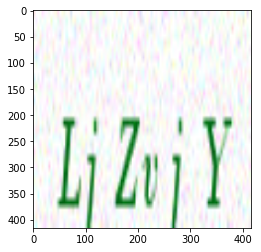

In [44]:
image = batches[0][0][0][0]
plt.imshow(image)

** Sanity check: show a few images with ground truth boxes overlaid **

In [19]:
len(LABELS)

62

In [20]:
x,b,y=batches[0][0][0],batches[0][0][1],batches[0][1]
print(x.shape,y.shape,b.shape)

(16, 416, 416, 3) (16, 13, 13, 5, 67) (16, 1, 1, 1, 50, 4)


# Construct the network

In [22]:
model = build_yolo_model()

# Load pretrained weights

**Load the weights originally provided by YOLO**

In [23]:
model = load_model_from_original_yolo_weights(model,wt_path)

## Setup a few callbacks and start the training

In [25]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_capcha.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [109]:
train_batch = BatchGenerator(images=all_imgs, config=generator_config,seed_start=0,seed_end=10000, norm=normalize)
valid_batch = BatchGenerator(images=all_imgs, config=generator_config,seed_start=11000,seed_end=12000, norm=normalize)


In [110]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-5, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)
# model.load_weights("weights_capcha.h5")
for i in range(200):
    model.fit_generator(generator        = train_batch, 
                        steps_per_epoch  = len(train_batch), 
                        epochs           = 100, 
                        verbose          = 1,
                        validation_data  = valid_batch,
                        validation_steps = len(valid_batch),
                        callbacks        = [early_stop, checkpoint], 
                        max_queue_size   = 3)

Epoch 1/100
625/625 [==============================] - 234s 374ms/step - loss: 0.1808 - val_loss: 0.0974

Epoch 00001: val_loss improved from 0.47879 to 0.09737, saving model to weights_capcha.h5
Epoch 2/100
625/625 [==============================] - 231s 370ms/step - loss: 0.0650 - val_loss: 0.0746

Epoch 00002: val_loss improved from 0.09737 to 0.07458, saving model to weights_capcha.h5
Epoch 3/100
625/625 [==============================] - 231s 369ms/step - loss: 0.0425 - val_loss: 0.0621

Epoch 00003: val_loss improved from 0.07458 to 0.06209, saving model to weights_capcha.h5
Epoch 4/100
625/625 [==============================] - 231s 370ms/step - loss: 0.0343 - val_loss: 0.0544

Epoch 00004: val_loss improved from 0.06209 to 0.05437, saving model to weights_capcha.h5
Epoch 5/100
625/625 [==============================] - 232s 371ms/step - loss: 0.0283 - val_loss: 0.0539

Epoch 00005: val_loss improved from 0.05437 to 0.05394, saving model to weights_capcha.h5
Epoch 6/100
625/625 

KeyboardInterrupt: 